In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#import warnings
#warnings.filterwarnings("ignore")

# Анализ оттока клиентов для сети фитнес клуба.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что пользователь больше не с нами? Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Чтобы бороться с оттоком, мы перевёли в электронный вид множество анкет пользователей.

### Задача — провести анализ клиентских анкет и подготовить маркетинговый план действий по удержанию клиентов.

1. [Подготовка данных](#step0) 
2. [Исследовательский анализ данных (EDA)](#step1)
3. [Модель прогнозирования оттока](#step2)
4. [Эксперимент](#step3)
5. [Кастеризация пользователей](#step4)
6. [Выводы](#step5)

## Подготовка данных <a id="step0"></a>

In [2]:
# прочитаем из csv-файла данные  распечатаем его
fitnes = pd.read_csv('/datasets/gym_churn.csv')
fitnes.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
def model(fitnes_new, threshold):
    # разделим наши данные на признаки (матрица X) и целевую переменную (y)
    X = fitnes_new.drop(columns = ['Churn'])
    y = fitnes_new['Churn']

    # разделяем модель на обучающую и валидационную выборку
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y , test_size=0.2, random_state=0)


    # обучим StandartScaler
    scaler = StandardScaler()
    scaler.fit(X_train)

    # Преобразуем обучающий и валидационные наборы данных
    X_train_st = scaler.transform(X_train)
    X_test_st = scaler.transform(X_test)

    # обучим модель
    lr_model = LogisticRegression()
    lr_model.fit(X_train_st, y_train)
    # воспользуемся уже обученной моделью, чтобы сделать прогнозы
    lr_predictions = lr_model.predict(X_test_st)
    lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
    

    # на основании вероятностей и соотношения классов рассчитаем custom_predictions 
    custom_predictions = [1 if i>threshold else 0 for i in lr_probabilities]

    print('Модель - Логистическая регрессия с кастомным порогом', threshold)
    print('Доля правильных ответов c порогом', threshold,': {:.2f}'.format(accuracy_score(y_test, custom_predictions)))
    print('Точность c порогом', threshold,': {:.2f}'.format(precision_score(y_test, custom_predictions)))
    print('Полнота c порогом', threshold,': {:.2f}'.format(recall_score(y_test, custom_predictions)))

### Добавление данных:

* Добавим **две метрики** на снове имеющейся информации 
<br>
* Первая - Srok_hoda - сколько человек уже отходил в фитнес клуб
* Вторая метрика old_client - это разнесем наших клиентов - на новых и старых по следующему признаку - если его срок хода в зал меньше чем время с момента обращения в зал - значит он уже брал абонимент и был посетителем, если же срок его пребывания в клубе равен первоначальному обращению - значит он впервые покупает абонемент. (1 - старый, 0 - новый)
И посмотрим  на датасет: есть ли в нем отсутствующие признаки

In [4]:
fitnes = fitnes.assign(Srok_hoda =  lambda x: x['Contract_period']-x['Month_to_end_contract'])

def old_client(df):
    if df['Lifetime'] >=2:
        return 1
    else:
        return 0
      
fitnes = fitnes.assign(old_client = lambda x: x.apply(old_client, axis=1))

fitnes.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [5]:
fitnes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 16 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
Srok_hoda                            4000 non-null float64
old_client                  

### Какие данные у нас есть.

* Churn - У нас есть 26%  оттока из всех четырех тысяч наблюдений нет никаких нулевых данных.
* gender - пол распределён вполне равномерно 
* Near_Location - около 84% проживают в районе или работают близ фитнес-клуба 
* Partner почти 50% клиентов фитнес-клуба пришли сюда из компаний партнеров и 30% при клиентов пришли сюда в рамках акции Приведи друга Promo_friends
* Age - возраст наш возраст клиентов от 18 до 41 в среднем 29 лет. Большая часть клиентов клуба от 27 до 31 года
* Lifetime время с момента первого обращения фитнес-клуб у нас от 1 до 31 месяца 3,7 это среднее время с момента первого обращения
* Contract_period - длительность текущего действия абонемента в среднем 4,6 месяца
* Month_to_end_contract - время до окончания текущего абонемента от 1 до 12 месяцев 
* Group_visits - групповые занятия в среднем 40% клиентов клуба посещают 
* Avg_class_frequency_total средняя частота посещений в неделю сначала действия абонемента от 1 до 6 раз в неделю и 1,87 среднем * Avg_class_frequency_current_month средняя частота посещений за предыдущий месяц 1,7 в среднем


### Посмотрим распределение ушедших и оставшихся клиентов - между новыми и старыми клиентами фитнес центра, а так же распределение между длинами абонемента.

In [6]:
group = fitnes.groupby('old_client')['Churn'].value_counts().to_frame().\
        rename(columns={'Churn':'count_cl'}).reset_index()#level = 'Churn')
summ = fitnes.groupby('old_client')['Churn'].count().reset_index().rename(columns={'Churn':'summ'})
group = group.merge(summ, on ='old_client').assign(oll_procent = lambda x: x['count_cl']/4000*100).\
                                            assign(procent = lambda x: x['count_cl']/x['summ']*100)
group

,old_client,Churn,count_cl,summ,oll_procent,procent
0,0,1,817,1330,20.425,61.428571
1,0,0,513,1330,12.825,38.571429
2,1,0,2426,2670,60.650,90.861423
3,1,1,244,2670,6.100,9.138577


**Оказалось, что мы теряем 62% от новых клиентов, и всего 9% от тех кто с нами уже давно.**

Посмотрим внимательно длинну абонемента. Кто-то остался а кто-то ушел.

In [7]:
summ = fitnes.groupby('Contract_period')['Churn'].value_counts().to_frame().\
            rename(columns={'Churn':'count_cl'}).reset_index().\
           merge(fitnes.groupby('Contract_period')['Churn'].count().reset_index().\
                 rename(columns={'Churn':'summ'}), on ='Contract_period')

summ.assign(procent = lambda x: x['count_cl']/x['summ']*100)

,Contract_period,Churn,count_cl,summ,procent
0,1,0,1273,2207,57.680109
1,1,1,934,2207,42.319891
2,6,0,729,833,87.515006
3,6,1,104,833,12.484994
4,12,0,937,960,97.604167
5,12,1,23,960,2.395833


**Получается что самая большая группа риска - это те, кто взял месячный абонимент. 42% клиентов с месячным абониментом уйдут от нас, это гигантская сумма.** 

In [8]:
summ.query('Churn == 1').assign(procent = lambda x: x['count_cl']/1061*100)

,Contract_period,Churn,count_cl,summ,procent
1,1,1,934,2207,88.030160
3,6,1,104,833,9.802074
5,12,1,23,960,2.167766


Посмотрим подробно тех, у кого абонимент 1 месяц.

In [9]:
fitnes.query('Contract_period == 1').groupby('old_client')['Churn'].value_counts().to_frame().\
                rename(columns={'Churn':'count_cl'})

count_cl
old_client Churn          
0          1           718
           0           225
1          0          1048
           1           216

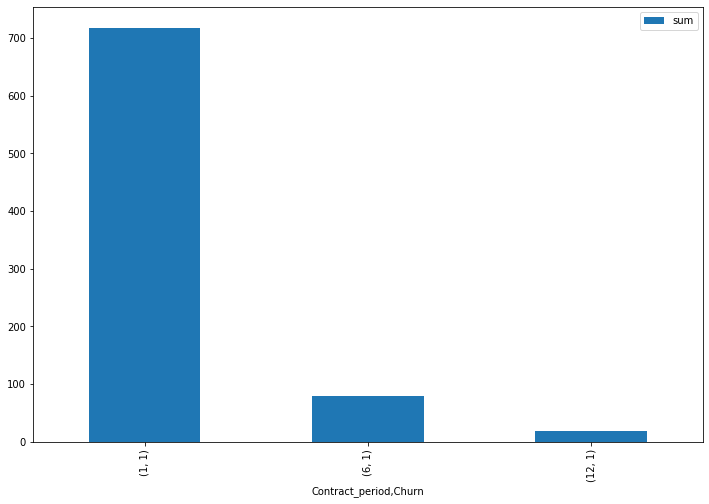

In [10]:
srez_n = fitnes.query('old_client == 0')[['Lifetime','Churn','Contract_period','Month_to_end_contract', 'Srok_hoda']]
srez_n.groupby('Contract_period')['Churn'].value_counts().to_frame().\
          rename(columns={'Churn':'sum'}).query('Churn == 1').plot.bar(figsize=(12, 8))
#ax.legend()
#plt.title('Отношение количества ушедших новых клиентов к длинне абонемента')
#plt.xlabel('Длительность текущего действующего абонемента ')
#plt.ylabel('Среднее количество посетителей')

#plt.show()

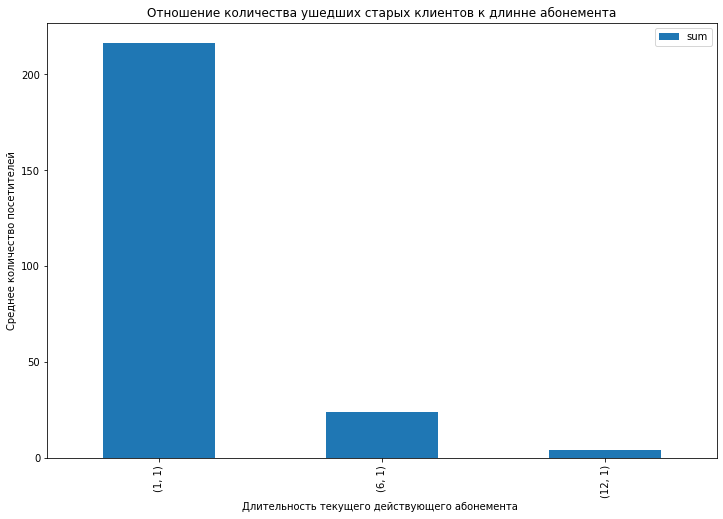

In [11]:
srez = fitnes.query('old_client == 1')[['Lifetime','Churn','Contract_period','Month_to_end_contract', 'Srok_hoda']]
srez.groupby('Contract_period')['Churn'].value_counts().to_frame().\
          rename(columns={'Churn':'sum'}).query('Churn == 1').plot.bar(figsize=(12, 8))
#ax.legend()
plt.title('Отношение количества ушедших старых клиентов к длинне абонемента')
plt.xlabel('Длительность текущего действующего абонемента ')
plt.ylabel('Среднее количество посетителей')

plt.show()

**Получаеться, что всех ушедших клиеентов - 1061 ,  есть одна большая группа 88% - тех кто покупает абонимент на 1 месяц и больше не возвращается. Из это группы можно выделить два типа - старые клиенты, которые уже чтото брали и новые - которые впервые в клубе, к каждой из групп нужно разное маркетинговое влияние, чтобы они остались в зале.**

* Часть - это старые клиенты которые купили месячный абонимент и перестали пользоватся нашими услугами - таких 216.
* И вторая большая группа - люди которые посетили клуб первый раз, взяли абонимент на месяц и дальше не стали покупать новый - таких оказалось 718 человека.


## Исследовательский анализ данных (EDA) <a id="step1"></a>

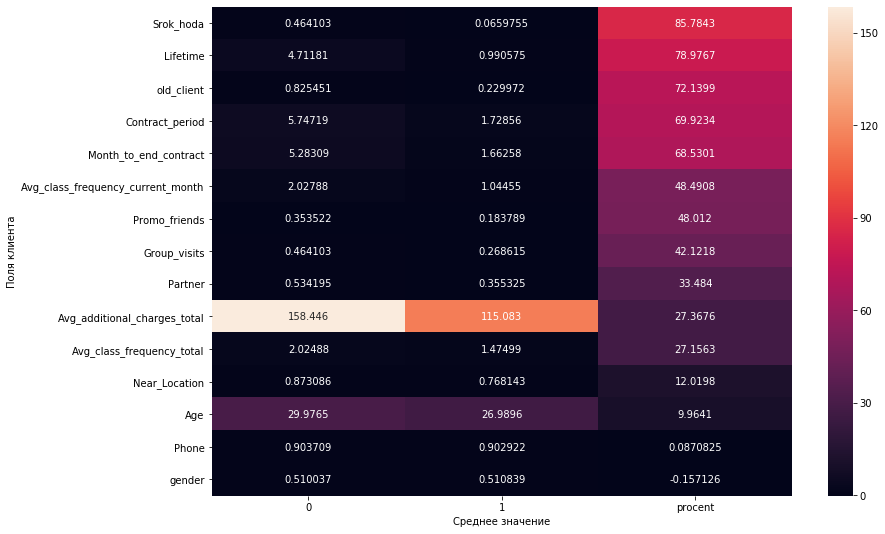

In [12]:
# составим таблицу и посомтрим метрики, с самым большим изменением у ушедших пользователей
table = fitnes.groupby('Churn').mean().T.assign(procent = lambda x:100- (x[1]/ x[0]*100)).sort_values(by = 'procent',ascending=False)#.loc[:,'procent']

plt.figure(figsize=(13, 9))
sns.heatmap(table, annot=True, fmt='g')
plt.xlabel('Среднее значение')
plt.ylabel('Поля клиента')
plt.show()


Нас интересует процент изменения у пользователей которые остались и у тех кто ушел.
>* Srok_hoda
>* Lifetime
>* Contract_period
>* Month_to_end_contract
>* Avg_class_frequency_current_month

эти метрики отличаються больше чем на 50 процентов у пользователей которые остались и у тех кто ушел.

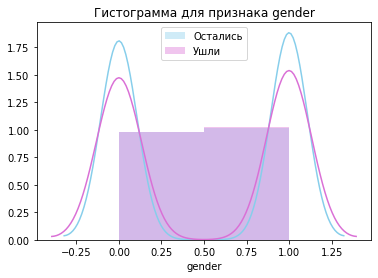

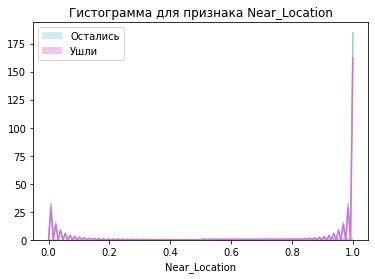

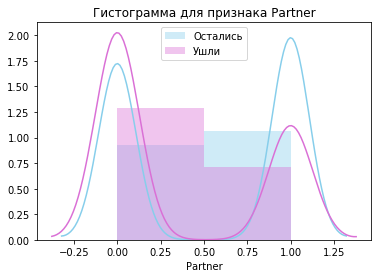

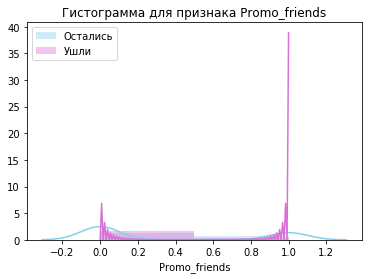

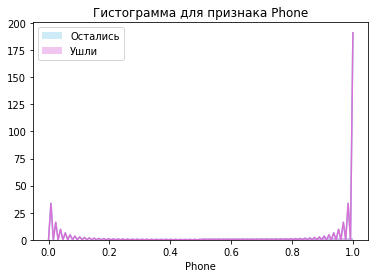

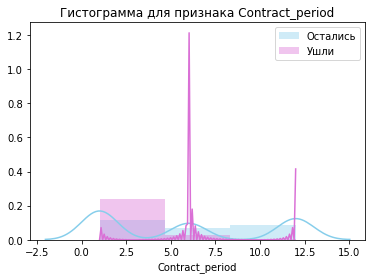

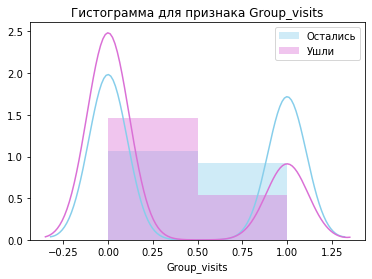

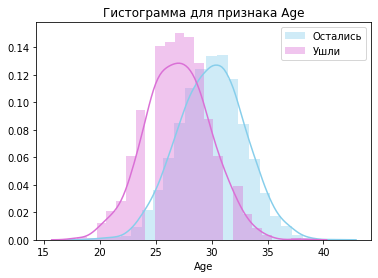

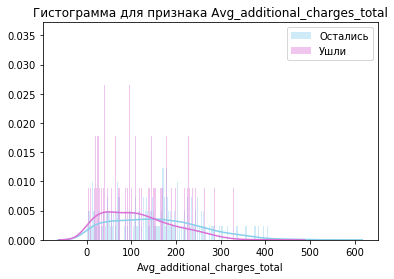

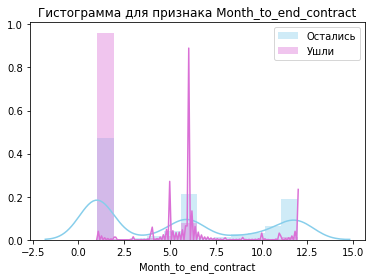

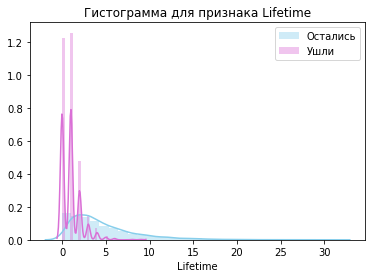

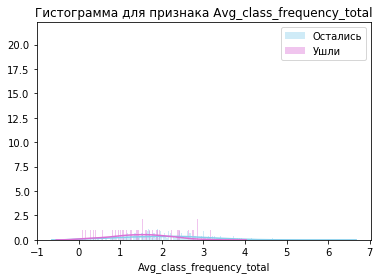

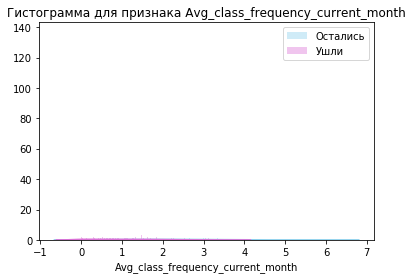

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


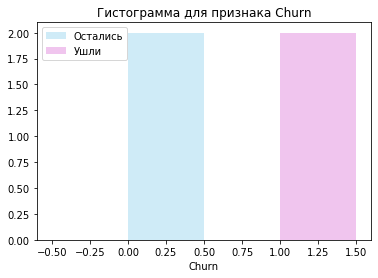

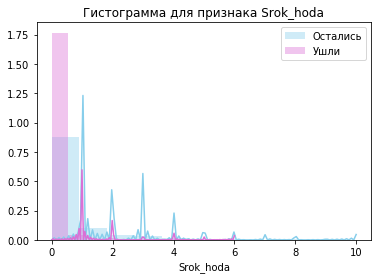

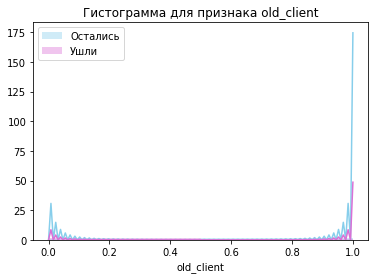

In [13]:
#yhod = fitnes.query('Churn==1')
for i in fitnes.columns.unique():
    
    bins = fitnes[i].nunique()
    ax = sns.distplot( fitnes.query('Churn==0')[i] , color="skyblue", label="Остались", bins = bins)
    ax = sns.distplot( fitnes.query('Churn==1')[i] , color="orchid", label="Ушли", bins = bins)#отток розовые
    ax.set_title('Гистограмма для признака '+ str(i))
    ax.legend()
  #  plt.legend()
  #  ax.set_title(i)
   # plt.xlim([-1,20])
  #  maxi = fitnes[i].max()
   # plt.ylim([0,maxi])
    plt.show()

Построим матрицу корреляций для основных признаков которые меняются у тех, кто собирается уйти.

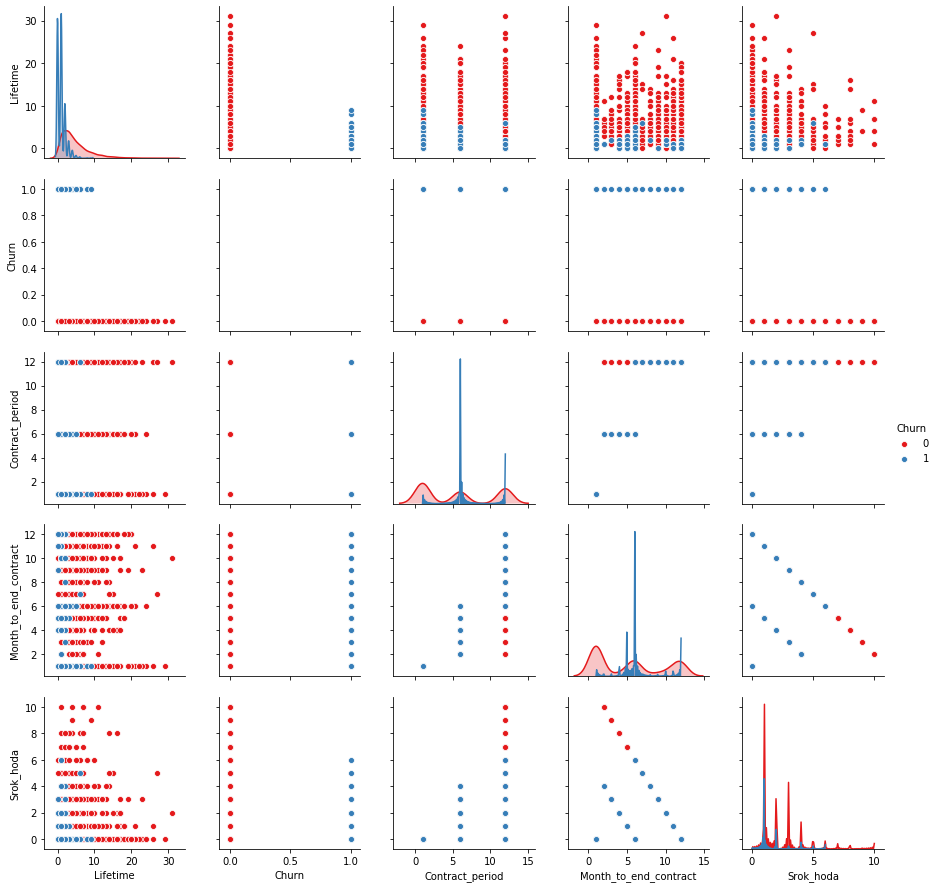

In [14]:
srex = fitnes[['Lifetime','Churn','Contract_period','Month_to_end_contract', 'Srok_hoda']]
sns.pairplot(srex, hue='Churn', palette='Set1');

>* Выводы: 
>* Получается что новые люди, которые посетили клуб купили клубную карту на один месяц а потом не пришли, скорее всего они получили быстрых результатов ради которого пришли в клуб. Они деляться в соотношении 60/40 - и с большей вероятностью покинут клуб. Гораздо интереснее клиенты которые уже были с нами долгое время и вдруг неожиданно решили уйти, предсказание именно этой группы может быть использовано в машинном обучение.

## Построим модель прогнозирования оттока пользователей по всей таблице <a id="step2"></a>

Recall метрика нацелена на минимизацию противоположных рисков — recall или полнота показывает, сколько реальных объектов "1" класса мы смогли обнаружить с помощью модели. Имеено эту метрику мы будем отслеживать, чтобы максимально найти всех кто потенциально может уйти из клуба.

**Посмотрим модель "Логистическая регрессия"**

In [15]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = fitnes.drop(columns = ['Churn'])
y = fitnes['Churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y , test_size=0.2, random_state=0)


# обучите StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуйте обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression()
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
# выведите все изученные метрики для полученного прогноза
print('Модель - Логистическая регрессия - стандартизованнная')
print('Доля правильных ответов: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Точность: {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('Полнота: {:.2f}'.format(recall_score(y_test, lr_predictions)))
#print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Модель - Логистическая регрессия - стандартизованнная
Доля правильных ответов: 0.93
Точность: 0.90
Полнота: 0.84


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Зададим кастомный порог- 0,22

In [16]:
model(fitnes, 0.22)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Модель - Логистическая регрессия с кастомным порогом 0.22
Доля правильных ответов c порогом 0.22 : 0.90
Точность c порогом 0.22 : 0.75
Полнота c порогом 0.22 : 0.95


Логистическая регрессия с кастомным порогом 0.22 - дает лучшую полноту по сравнению с обычной регрессией.

**Посмотрим модель "Случайный лес"**

In [17]:
# задайте алгоритм для нашей модели
model_forest =RandomForestClassifier()

# обучите модель
model_forest.fit(X_train, y_train)

# воспользуйтесь уже обученной моделью, чтобы сделать прогнозы
predictions_forest = model_forest.predict(X_test)
probabilities_forest = model_forest.predict_proba(X_test)[:,1]


# выведите все изученные метрики для полученного прогноза
print('Модель - Случайный лес')
print('Доля правильных ответов: {:.2f}'.format(accuracy_score(y_test, predictions_forest)))
print('Точность: {:.2f}'.format(precision_score(y_test, predictions_forest)))
print('Полнота: {:.2f}'.format(recall_score(y_test, predictions_forest)))
#print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Модель - Случайный лес
Доля правильных ответов: 0.91
Точность: 0.88
Полнота: 0.77


Пока самая успешная модель - Логистическая регрессия с кастомным порогом 0,2. Посмотрим какие коэффиценты она предлагает

In [18]:
feature_weights = lr_model.coef_.tolist()
import itertools
merged = list(itertools.chain.from_iterable(feature_weights))

fi_df = pd.DataFrame(index =  X.columns)
fi_df['weight'] = merged

fi_df.sort_values('weight', ascending = False)

,weight
Avg_class_frequency_total,3.131049
gender,-0.011318
Srok_hoda,-0.014029
Phone,-0.022593
Near_Location,-0.055569
Partner,-0.074634
Promo_friends,-0.145595
old_client,-0.332840
Group_visits,-0.403135
Avg_additional_charges_total,-0.562444


**Попробуем уточнить модель, добавив в ее работу только те поля, которые однозначно изменяются ближе к уходу человека.**
+ Contract_period и Month_to_end_contract мы переделали в одно поле Srok_hoda, поэтому будем использовать в моделе только одно поле из двоих- Contract_period. 
+ Так же добавим Age, видим что он хоть и имеет небольшой вес , но среднее значение возраста у тех , кто ушел - 26 лет, а у тех кто остался - 32 года.
+ Lifetime - обязательно , он засветился высоким коэффицентом и в тепловой карте где мы рассматривали среднее и в коэффициенте логистчиеской регрессии. 
+ Avg_class_frequency_total, Avg_class_frequency_current_month  - видим что второй снижается относительно первого для тех, кто собирается уходить.
+ Avg_class_frequency_total - тратят меньше те, кто собирается уходить.
+ Group_visit, чаще занимаются в одиночку и не приглаешены -  Partner - значит потенциальные Бывшие Клиенты.

In [19]:
strandg_fitnes = fitnes[['Lifetime','Srok_hoda','Age','Churn','Partner','Contract_period', 'Avg_additional_charges_total','Avg_class_frequency_total','Avg_class_frequency_current_month']]

In [20]:
model(strandg_fitnes, 0.2)

Модель - Логистическая регрессия с кастомным порогом 0.2
Доля правильных ответов c порогом 0.2 : 0.90
Точность c порогом 0.2 : 0.73
Полнота c порогом 0.2 : 0.97


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



#### Это лучшая модель , если не делить клиентов на новых и старых

Получается, что добавив не всe поля в нашу модель мы смогли улучшить предсказание и повысили Долю правильных ответов и Точность на 1%, при этом полнота сохранилась на уровне 97%. А значит что 97% клиентов фитнес клуба мы можем предсказать уход за месяц до их решения и попробовать их остановить.


### Проведем эксперимент <a id="step3"></a>

**Есть идея, что если обучить модель отдельно для старых клиентов. она будет давать лучше результаты для оценки новых клиентов.**

In [21]:
print('Модель отдельно для старых клиентов')
fitnes_old  = fitnes.query('old_client==1').copy()
model(fitnes_old, 0.10)


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Модель отдельно для старых клиентов
Модель - Логистическая регрессия с кастомным порогом 0.1
Доля правильных ответов c порогом 0.1 : 0.91
Точность c порогом 0.1 : 0.50
Полнота c порогом 0.1 : 0.98


Повысили полноту еще на  1%

**Попробуем выделить из выборки только тех, кто купил абонимент на 1 месяц и сделать прогноз по ним.**

In [22]:
print('Модель отдельно для абонементов на 1 месяц')
fitnes_1  = fitnes.query('Contract_period==1')[['Lifetime','Srok_hoda','Age','Churn','Partner','old_client',
                                                  'Avg_additional_charges_total','Avg_class_frequency_total',
                                                  'Avg_class_frequency_current_month']].copy()

model(fitnes_1, 0.17)

Модель отдельно для абонементов на 1 месяц
Модель - Логистическая регрессия с кастомным порогом 0.17
Доля правильных ответов c порогом 0.17 : 0.86
Точность c порогом 0.17 : 0.76
Полнота c порогом 0.17 : 0.97


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Наш эксперимент закончился положительно. Получаеться что если поделить клиентов по срокам абонимента и по - новый или старый это клиент - можно повысить точность модели.

<div class="alert alert-success">
<h2> Комментарий ревьюера</h2>

В том числе рекомендую смотреть на метрику `ROC–AUC`. 

Является одна из основных метрик оценок моделей классификации.
    
Ниже статья, в которой есть материалы про метрики и как их визуализировать.
    
https://habr.com/ru/company/ods/blog/328372/

</div>

### Кластеризация пользователей <a id="step4"></a>

Оставим для кластеризации только те столбцы, которые наиболее относятся к пользователю, и уберем столбец оттока.

In [23]:
strandg_fitnes = fitnes#[['Lifetime','Srok_hoda','Churn','Partner','Contract_period', 'Avg_additional_charges_total','Avg_class_frequency_total','Avg_class_frequency_current_month']]
sc = StandardScaler()
x_sc = sc.fit_transform(strandg_fitnes.drop(columns = ['Churn', 'Phone', 'gender','Age', 'old_client']))
linked = linkage(x_sc, method = 'ward')


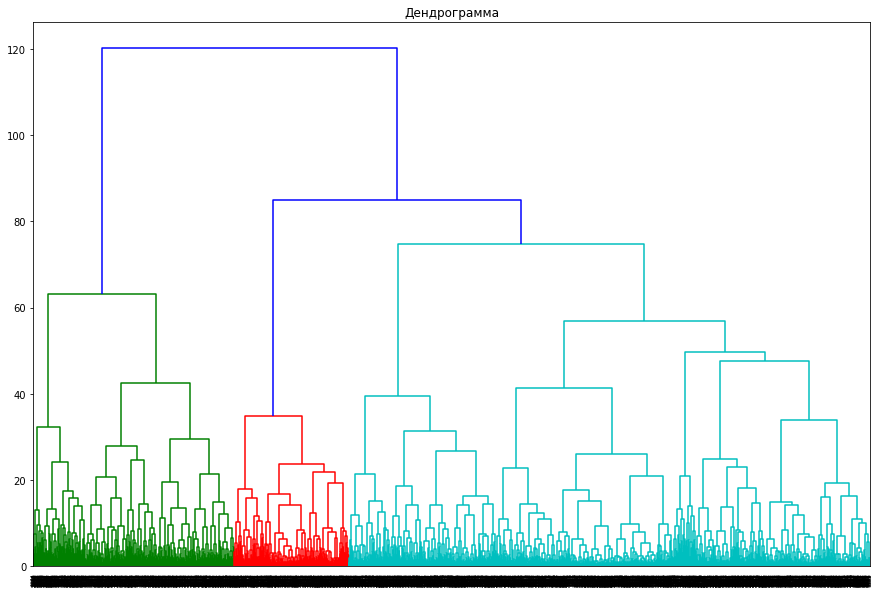

In [24]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма')
plt.show()

Получили 3 кластера, но попробуем разбить методом KMeans на 5 групп.

<div class="alert alert-success">
<h2> Комментарий ревьюера</h2>

В том числе чтобы определить количество кластеров можно использовать метод локтя. 
    
Ниже статья с двумя методами, которые можно в том числе использовать для определения количества кластеров.
    
https://habr.com/ru/company/jetinfosystems/blog/467745/
    
</div>

In [25]:
km = KMeans(n_clusters = 5, random_state=0)
 
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
strandg_fitnes['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
strandg_fitnes.groupby('cluster_km').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,Srok_hoda,old_client
cluster_km,,,,,,,,,,,,,,,,
0,0.500924,0.000000,0.458410,0.077634,0.916821,2.073937,0.207024,28.598891,134.564003,2.007394,2.774492,1.682561,1.492452,0.449168,0.066543,0.556377
1,0.538136,0.984110,0.364407,0.269068,0.900424,2.476695,0.469280,29.765890,161.146803,2.396186,5.034958,2.800231,2.793503,0.084746,0.080508,0.810381
2,0.512847,0.950668,0.778006,0.585817,0.894142,10.735868,0.526208,29.778006,161.570155,10.339157,4.533402,1.913399,1.900718,0.039054,0.396711,0.793422
3,0.500000,0.927885,0.701923,0.389423,0.923077,11.250000,0.605769,29.980769,157.893253,7.062500,5.086538,2.219963,2.206921,0.033654,4.187500,0.807692
4,0.494003,1.000000,0.338831,0.215142,0.904048,1.858321,0.341829,28.452774,129.537965,1.809595,2.380810,1.228565,0.985971,0.519490,0.048726,0.497751


In [26]:
strandg_fitnes.groupby('cluster_km')['Churn'].mean()

cluster_km
0    0.449168
1    0.084746
2    0.039054
3    0.033654
4    0.519490
Name: Churn, dtype: float64

Получается из наших клиентов мы нашли 5 кластеров - из которых 2 - потенциально уйдут, а 3 точно останутся. Сравним полярные кластеры, чтобы уцвидеть их различия

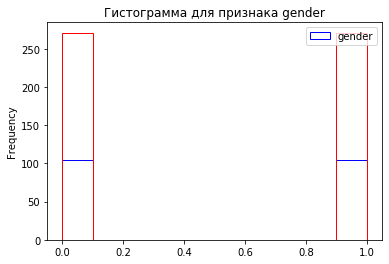

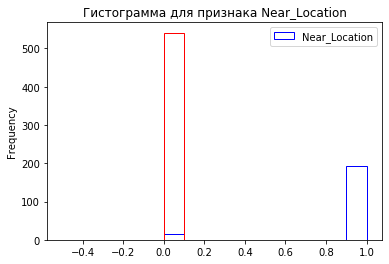

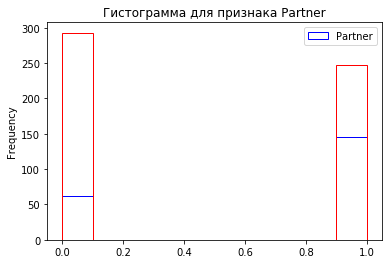

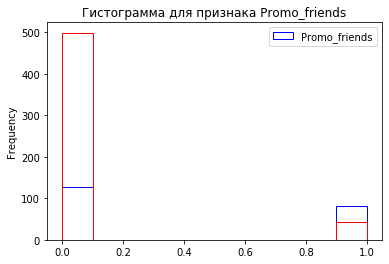

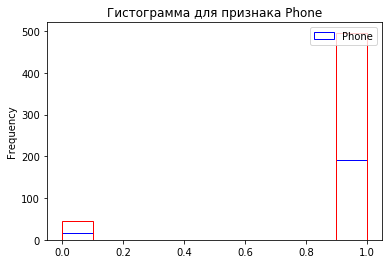

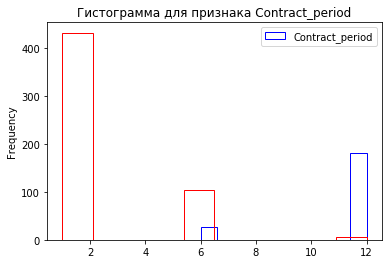

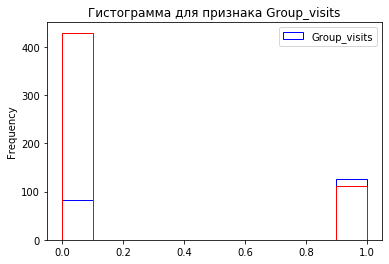

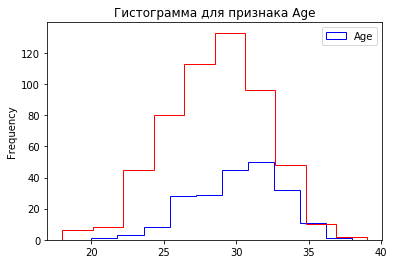

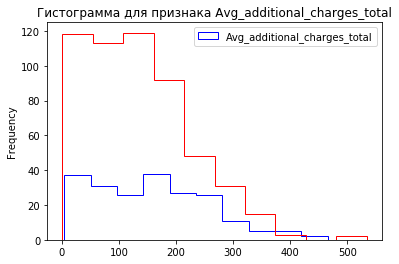

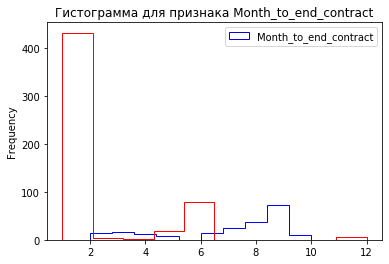

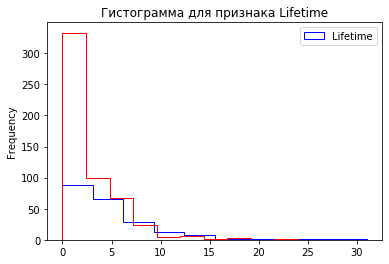

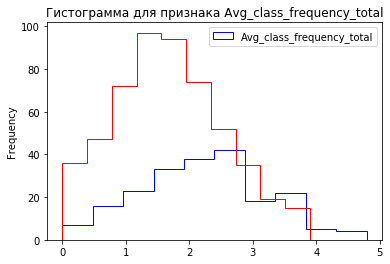

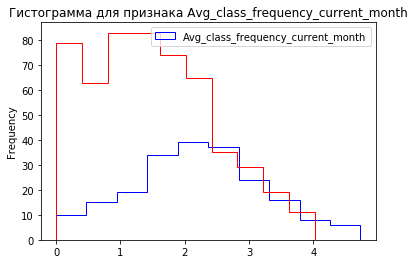

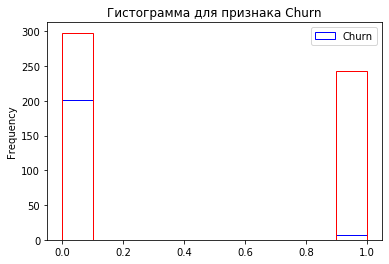

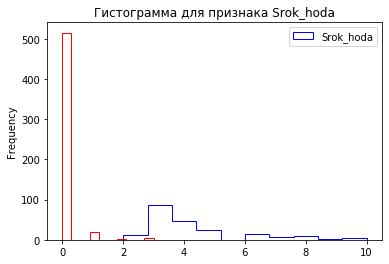

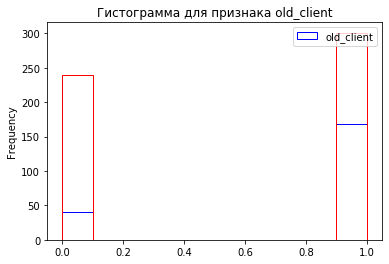

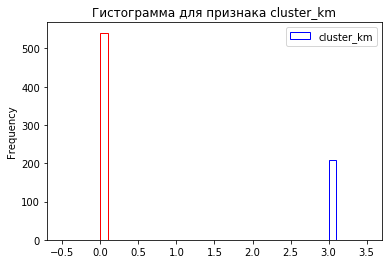

In [27]:
interest = strandg_fitnes.query('cluster_km==3 or cluster_km==0')

for column in interest:
    interest.query('cluster_km == 3')[column].\
        plot(kind='hist', alpha=1, histtype = 'step',color = 'blue', title='Гистограмма для признака '+ str(column), legend = True)
    interest.query('cluster_km == 0')[column].\
        plot(kind='hist', alpha=1, color = 'red', histtype = 'step')
    plt.show()

>* Выводы:

Мы опять будем тоже картину лайфтайм пользователя которые уйдут значительно короче чем лайфтайм остальных пользователей.Также мы видим разницу в географии те пользователи которые скорей всего уйдут - чаще находятся Вне нашей зоне локации. Их контракт заканчивается они не хотят его продлевать.

### Выводы <a id="step5"></a>

#### Всех наших клиентов мы можем разделить на новичков - кто впервые купил абонимент и старичков, кто это делает не в первый раз.

Мы видим Что 88% людей теряется из тех кто купил месячный абонемент именно с ними нужно работать для того чтобы их первый поход в клуб не закончился на этом а продолжался дальше. Часть - это старые клиенты которые купили месячный абонимент и перестали пользоватся нашими услугами - таких 216.
И вторая большая группа - люди которые посетили клуб первый раз, взяли абонимент на месяц и дальше не стали покупать новый - таких оказалось 718 человека.

### Стартегия маркетинговых активностей относительно каждого кластера клиентов:

#### Новый клиент:

>* Задача: понять почему качество входящих клиентов которые заключают договор на один месяц настолько низкое - тут либо входящий трафик очень плохой и клиенты не ценят того что получают за месячный абонемент, либо предложение в клубе очень плохое и клиенты не получают того ради чего заплатили за это месячный абонемент.

Если при опросе клиентов выяснится что их заманивали бесплатном абонементам а в принципе он им не нужен значит нужно пересмотреть программу для привлечения клиентов. Если же после опроса клиента выяснится что его уход связан с тем что он не получил в клубе того зачем шел - значит надо пересмотреть политику клуба и предлагаемые услуги.

>* Идеи для новых клиентов: сделать скидку в размере 50% на второй абонемент после покупки на один месяц продолжение номер два везти в клубе абонемента на 3 месяца и предложить их их тем кто уже купил абонемент на 1 месяц для тех у кого лайфтайм меньше 2 месяцев.


#### Старый клиент:

Если жизнь не меняется то есть всего 2 причины чтобы бросить - деньги или время кончилось. Под временем мы подразумеваем - изменилось место работы или проживания рядом с клубом и ездить стало просто неудобно.

>* Идея для старых клиентов: если не хватает денег - предложить рассрочку платежа, какие - либо бесплатные услуги, чтобы клиент чувствовал внимание и заботу со стороны клуба даже если ситуация оставляет желать лучшего. Именно тогда он останется и станет амбассадором бренда.